# CS M148 Final Project

### Import Modules

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline

import random 
  
random.seed(42) 

In [3]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## The Dataset
Loading the dataset and printing basic info about it.

In [4]:
stroke = pd.read_csv("./healthcare-dataset-stroke-data.csv")
print(stroke.head())
print(stroke.describe())
print(stroke.info())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
                 id          age  hypertension  heart_di

#### Checking for null values

In [5]:
stroke.isnull().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

Here we can see that only the bmi (body mass index) contains any null values in the dataset. This will be dealt with later.

#### Histogram of numerical columns

/mnt/c/Users/ryanr/OneDrive/Desktop/UCLA/CSM148/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'hypertension'}>],
       [<AxesSubplot:title={'center':'heart_disease'}>,
        <AxesSubplot:title={'center':'avg_glucose_level'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'stroke'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

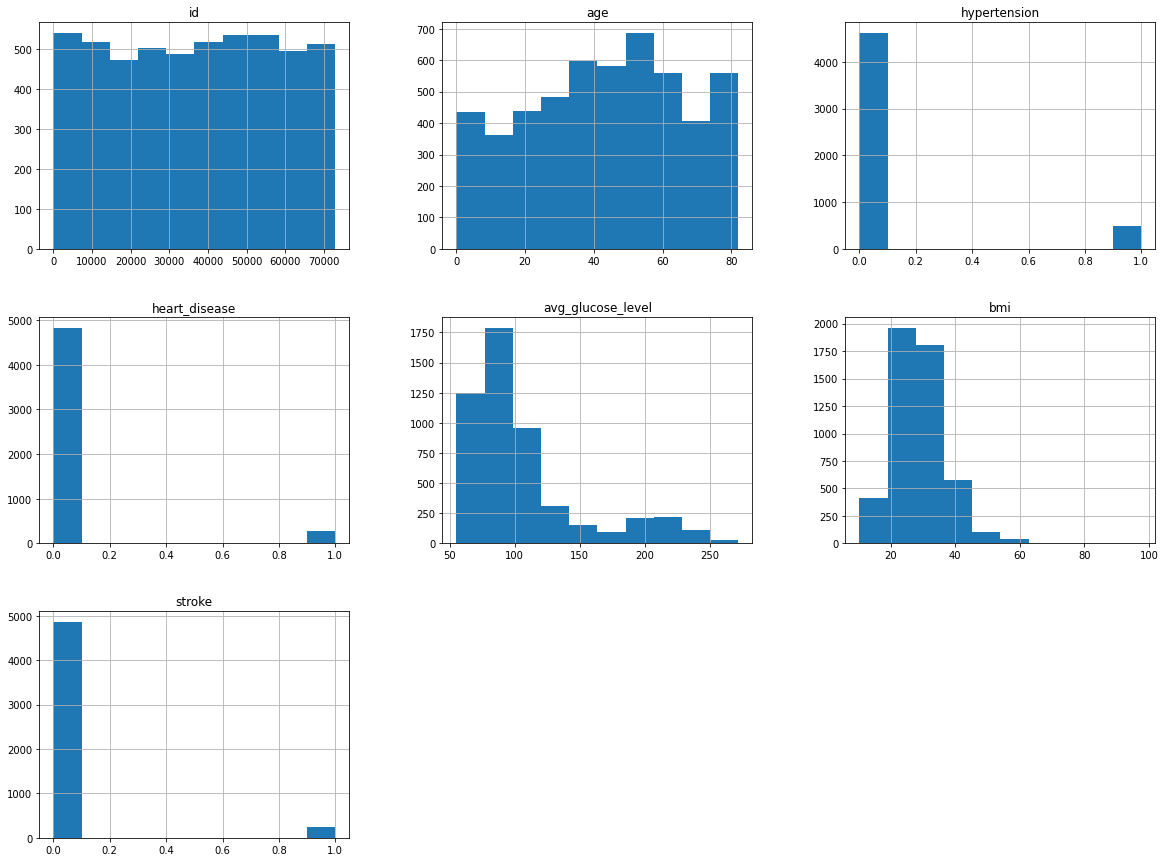

In [6]:
stroke.hist(bins=10, figsize=(20, 15))

From looking at these histograms, we can see that age, avg_glucose_level, and bmi have somewhat normal distributions. hypertension, heart_disease, and stroke are all highly skewed towards 0 (false). This gives me a baseline susbicion that these are very closely correlated.

#### Correlation Charts

<AxesSubplot:>

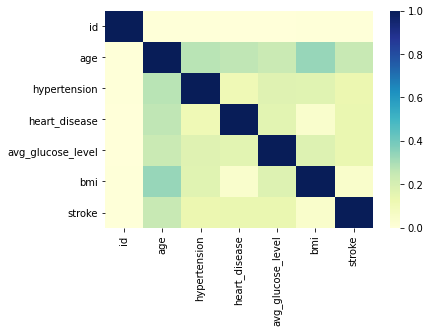

In [7]:
sns.heatmap(stroke.corr(), cmap="YlGnBu")

With just a quick look at the correlations, we notice that there is no large obvious correlation. Age seems to be most correlatd with all the other variables, and besides that there are no other significant correlations.

In [8]:
stroke["stroke"].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

## Data Pipeline

Data pipeline to process the raw data.

In [9]:
from sklearn.utils import resample

majority = stroke[stroke["stroke"]==0]
minority = stroke[stroke["stroke"]==1]

minority_upsampled = resample(minority, replace=True, n_samples = 4861, random_state=0)

stroke_upsampled = pd.concat([minority_upsampled,majority])

stroke_upsampled["stroke"].value_counts()

0    4861
1    4861
Name: stroke, dtype: int64

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

stroke_features = stroke_upsampled.drop(["stroke", "id"], axis=1) # drop labels for training set features
                                                       # the input to the model should not contain the true label
stroke_labels = stroke_upsampled["stroke"].copy()

imputer = SimpleImputer(strategy="median") # use median imputation for missing values

categorical_features = ["gender", "heart_disease", "hypertension", "ever_married", "work_type", "Residence_type", "smoking_status"]
stroke_num = stroke_features.drop(categorical_features, axis=1) # remove the categorical feature
numerical_features = list(stroke_num)

# column index
bmi_idx, glucose_idx = 2, 1

# 
class AugmentFeatures(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        bmi_glucose = X[:, bmi_idx] / X[:, glucose_idx]
        return np.c_[X, bmi_glucose]

# this will be are numirical pipeline
# 1. impute, 2. augment the feature set 3. normalize using StandardScaler()
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', AugmentFeatures()),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ])

stroke_prepared = full_pipeline.fit_transform(stroke_features)

### Train Test Split

In [11]:
train,test,target,target_test = train_test_split(stroke_prepared, stroke_labels, test_size = 0.167)

## Logistic Regression

In [12]:
logistic = LogisticRegression(penalty='l2', solver='newton-cg', class_weight = 'balanced')
log_reg = logistic.fit(train, target)


Accuracy: 0.7727832512315271
Precision: 0.7526627218934911
Recall: 0.7989949748743719
F1: 0.7751371115173674


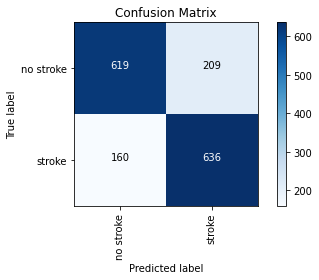

In [13]:
from sklearn.metrics import precision_recall_fscore_support

results = log_reg.predict(test)
precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Accuracy: {log_reg.score(test, target_test)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['no stroke', 'stroke'])

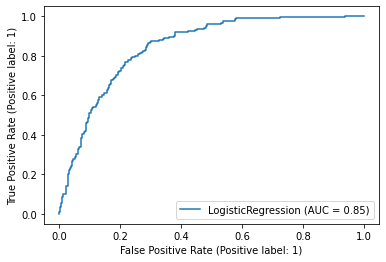

In [14]:
# ROC curve
metrics.plot_roc_curve(log_reg, test, target_test)
plt.show()

## Principal Component Analysis

In [15]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
pca.fit(train)

pca_train = pca.transform(train)
pca_test = pca.transform(test)

Accuracy: 0.770935960591133
Precision: 0.75
Recall: 0.7989949748743719
F1: 0.7737226277372263


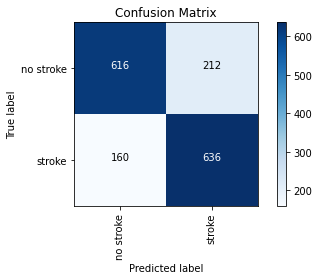

In [16]:
#logistic regression with pca features
lg = logistic.fit(pca_train, target)

from sklearn.metrics import precision_recall_fscore_support

results = lg.predict(pca_test)
precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Accuracy: {lg.score(pca_test, target_test)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['no stroke', 'stroke'])

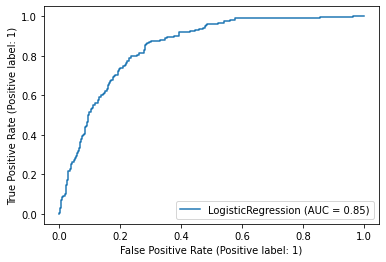

In [17]:
# ROC curve
metrics.plot_roc_curve(lg, pca_test, target_test)
plt.show()

## Bagging Classifier

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

bg = BaggingClassifier(base_estimator=SVC(),n_estimators=10,random_state=0).fit(pca_train,target)

Accuracy: 0.854679802955665
Precision: 0.8070175438596491
Recall: 0.9246231155778895
F1: 0.8618266978922717


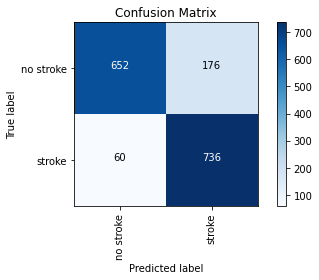

In [19]:
results = bg.predict(pca_test)

precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Accuracy: {bg.score(pca_test, target_test)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['no stroke', 'stroke'])

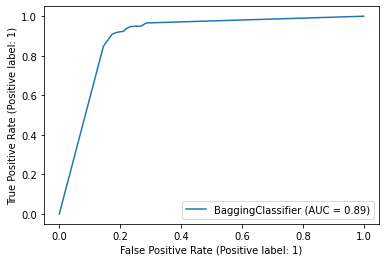

In [20]:
# ROC curve
metrics.plot_roc_curve(bg, pca_test, target_test)
plt.show()

## Neural Net

In [21]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(solver='lbfgs', alpha=1e-6, random_state=0, max_iter=3000)
nn.fit(pca_train, target)

MLPClassifier(alpha=1e-06, max_iter=3000, random_state=0, solver='lbfgs')

Accuracy: 0.9642857142857143
Precision: 0.9320843091334895
Recall: 1.0
F1: 0.9648484848484848


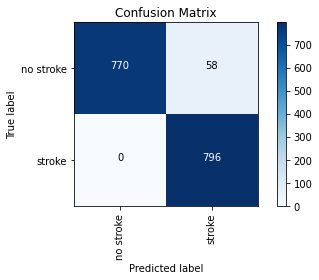

In [22]:
results = nn.predict(pca_test)

precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Accuracy: {nn.score(pca_test, target_test)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['no stroke', 'stroke'])

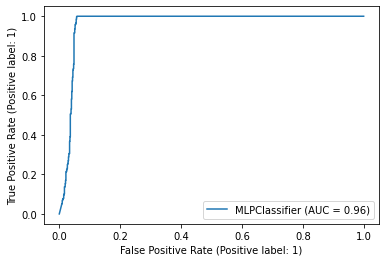

In [23]:
# ROC curve
metrics.plot_roc_curve(nn, pca_test, target_test)
plt.show()

## Random Forrest

Accuracy: 0.9895320197044335
Precision: 0.9790897908979089
Recall: 1.0
F1: 0.9894344313238035


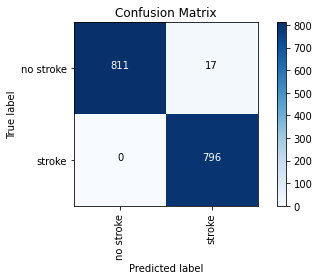

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, random_state=0)
rf.fit(pca_train, target)


results = rf.predict(pca_test)

precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Accuracy: {rf.score(pca_test, target_test)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['no stroke', 'stroke'])

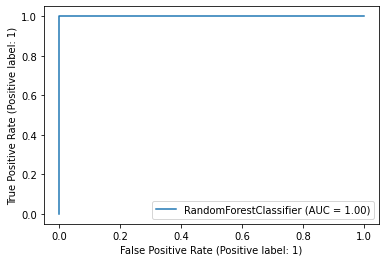

In [25]:
# ROC curve
metrics.plot_roc_curve(rf, pca_test, target_test)
plt.show()

## Cross Validation

Accuracy: 0.7974402537093668
Precision: 0.7718277066356228
Recall: 0.8329145728643216
F1: 0.8012084592145015


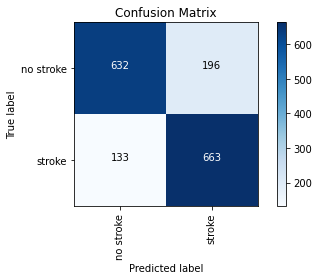

In [26]:
# Bagging Ensemble
kfold = KFold(n_splits=15, random_state=42, shuffle=True)

results = cross_val_predict(bg, pca_test, target_test, cv=kfold)

precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Accuracy: {cross_val_score(bg, pca_test, target_test, cv=kfold).mean()}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['no stroke', 'stroke'])

Accuracy: 0.8891324045758296
Precision: 0.835511982570806
Recall: 0.9635678391959799
F1: 0.894982497082847


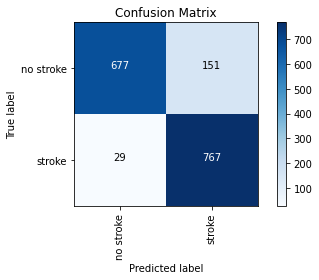

In [27]:
# Neural Net
kfold = KFold(n_splits=15, random_state=42, shuffle=True)

results = cross_val_predict(nn, pca_test, target_test, cv=kfold)

precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Accuracy: {cross_val_score(nn, pca_test, target_test, cv=kfold).mean()}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['no stroke', 'stroke'])

Accuracy: 0.9249122210895911
Precision: 0.884703196347032
Recall: 0.9736180904522613
F1: 0.9270334928229665


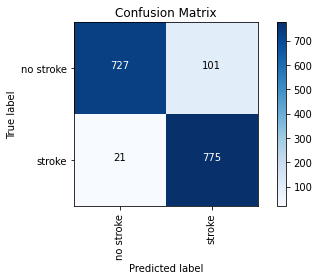

In [28]:
# random forrest

results = cross_val_predict(rf, pca_test, target_test, cv=kfold)

precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Accuracy: {cross_val_score(rf, pca_test, target_test, cv=kfold).mean()}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['no stroke', 'stroke'])

Accuracy: 0.7685185185185186
Precision: 0.7436194895591647
Recall: 0.8052763819095478
F1: 0.7732207478890228


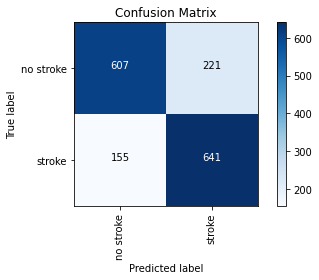

In [29]:
# logistic regression

results = cross_val_predict(lg, pca_test, target_test, cv=kfold)

precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Accuracy: {cross_val_score(lg, pca_test, target_test, cv=kfold).mean()}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['no stroke', 'stroke'])